<a href="https://colab.research.google.com/github/yoav1131/Deep-Learning-Course/blob/main/Transofmers_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training Transformers

In this notebook we will provide an example of training transformers for text processing. As transformers are quite a heavy machinery, we will only use the encoder module of the transformer, and show how its output can be used for sentiment analysis, as we did with RNNs.

Once again, as we dealing with text processing, we will utilize *torchtext package*. Specifically, today we will carry out sentiment analysis based on movie reviews, taken from the IMDB review dataset.

In [1]:
!pip install torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118 torchtext==0.17.2 \
  --extra-index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 120.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 133.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install numpy

In [3]:
!pip install torchdata portalocker

In [8]:
import os
import re
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as f
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# IMDB Review Dataset

The IMDB review dataset is comprised of movie reviews gathered by the IMDB website. Each review is accompanied with a sentiment score, indicating whehter or not the reviewer like the movie.
This dataset is available via the *torchtext.datasets* package, so the first thing we do is load it.

In [5]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2026-01-03 07:13:08--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  59.7MB/s    in 1.3s    

2026-01-03 07:13:10 (59.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [118]:
def load_imdb(path):
    """
    This function loads IMDB reviews from disk.

    Inputs:
    - path: directory containing 'pos' and 'neg' subfolders

    Outputs:
    - texts: list of raw text reviews (strings)
    - labels: list of integers (1 = positive, 0 = negative)

    This explicit loading is transparent and ideal for teaching.
    """
    texts, labels = [], []
    for label in ["pos", "neg"]:
        folder = os.path.join(path, label)
        for fname in os.listdir(folder):
            with open(os.path.join(folder, fname), encoding="utf-8") as f:
                texts.append(f.read())
                labels.append(1 if label == "pos" else 0)
    return texts, labels

train_texts, train_labels = load_imdb("aclImdb/train")
test_texts, test_labels = load_imdb("aclImdb/test")

print(len(train_texts), "training samples")
print(len(test_texts), "test samples")

25000 training samples
25000 test samples


Each entry in the data set consists of a text sequence and a categorical sentiment, as shown below:

In [119]:
"""
Inspect a few raw training samples to understand the data.
This replaces the legacy `line.text` / `line.label` pattern.
"""

for i, (text, label) in enumerate(zip(train_texts, train_labels)):
    if i >= 10:
        break
    print(f"Sample {i}")
    print("Label:", "pos" if label == 1 else "neg")
    print("Text preview:", text)
    print("-" * 80)


Sample 0
Label: pos
Text preview: I really don't understand why people get so upset and pan this movie! Remember folks, this is an SNL movie, not anything that is supposed to be unpredictable and original in plot or direction! The Ladies Man is a hilarious movie, albeit stupid at times, with a wacked-out cast and, as usual, WONDERFUL performances by Will Ferrel and Tim Meadows. Yes some of the jokes are stupid, and yes, the characters are unbelievable but its comedy! I really don't understand how anyone couldn't laugh a lot during this hilarious film. Anyway, all I ask is that people take this as it is--an SNL, silly and irreverent comedy. Nothing that will win awards, but nonetheless, some modern comedy gold. "10-4 Apricot!"
--------------------------------------------------------------------------------
Sample 1
Label: pos
Text preview: The film transported everyone back to October 20, 1944 where we seemed to be part of the great Philippine 'I Shall Return' landing scene It was on t

In [120]:
def tokenize(text):
    """
    Lowercases and splits text into word tokens.
    """
    return re.findall(r"\b\w+\b", text.lower())


In [136]:
def yield_tokens(texts):
  for text in texts:
    yield tokenize(text)


vocab = build_vocab_from_iterator(
yield_tokens(train_texts),
max_tokens=50_000,
specials=["<unk>"] # "<unk>" means unkown word (the word is not in my corpus)
)


# THIS IS MANDATORY
vocab.set_default_index(vocab["<unk>"])

In [137]:
# vocab = build_vocab(train_texts)
vocab_size = len(vocab)
vocab_size


50000

In [138]:
def encode_text(text, vocab, max_len=200):
    """
    Converts text to a fixed-length list of word indices.

    Steps:
    1. Tokenize
    2. Convert to indices
    3. Truncate to max_len
    4. Pad to max_len (here we don't use padding!!)
    """
    tokens = tokenize(text)
    ids = [vocab[tok] for tok in tokens]


    # truncate
    ids = ids[:max_len]

    # # pad
    # if len(ids) < max_len:
    #     ids += [vocab["<pad>"]] * (max_len - len(ids))

    return ids


In [139]:
class IMDBDataset(Dataset):
  """
  Returns:
  text_tensor : LongTensor (variable length)
  label : int (0 or 1)
  """
  def __init__(self, texts, labels, vocab, max_len):
    self.texts = texts
    self.labels = labels
    self.vocab = vocab
    self.max_len = max_len


  def __len__(self):
    return len(self.texts)


  def __getitem__(self, idx):
    text_tensor = encode_text(self.texts[idx], self.vocab, self.max_len)
    label = self.labels[idx]
    return text_tensor, label

In [140]:
from collections import defaultdict

def build_length_buckets(dataset):
    """
    Groups dataset indices by sequence length.
    """
    buckets = defaultdict(list)

    for idx in range(len(dataset)):
        tokens, _ = dataset[idx]
        buckets[len(tokens)].append(idx)

    return buckets


In [141]:
from torch.utils.data import Sampler
import random

class SameLengthBatchSampler(Sampler):
    """
    Yields batches of indices where all sequences
    have the same length.
    """

    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.buckets = build_length_buckets(dataset)
        self.batches = self._create_batches()

    def _create_batches(self):
        batches = []

        for length, indices in self.buckets.items():
            if self.shuffle:
                random.shuffle(indices)

            for i in range(0, len(indices), self.batch_size):
                batch = indices[i:i + self.batch_size]
                if len(batch) == self.batch_size:
                    batches.append(batch)

        if self.shuffle:
            random.shuffle(batches)

        return batches

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)


In [142]:
def collate_no_pad(batch):
    """
    Collate function for SAME-LENGTH batches.
    No padding, no sorting.
    """
    texts, labels = zip(*batch)

    texts = torch.stack(
        [torch.tensor(t, dtype=torch.long) for t in texts]
    )

    labels = torch.tensor(labels, dtype=torch.long)

    return texts, labels


Now that we understand what is the data we are dealing with, we divide it into train, validation, and label. We use $10\%$ of the training data as validation.

In [143]:
MAX_LEN = 200
ds_train = IMDBDataset(train_texts, train_labels, vocab, MAX_LEN)
ds_test  = IMDBDataset(test_texts, test_labels, vocab, MAX_LEN)


In [144]:
labels = train_labels   # original labels list (before Dataset creation)
splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.1,
    random_state=42
)

In [145]:
train_idx, valid_idx = next(
    splitter.split(train_texts, labels)
)


In [146]:
ds_train = Subset(ds_train, train_idx)
ds_valid = Subset(ds_train.dataset, valid_idx)


In [147]:
print('train : ', len(ds_train))
print('valid : ', len(ds_valid))
print('test : ', len(ds_test))

train :  22500
valid :  2500
test :  25000


**Batching:** We will again do batching by sequence length. This time, we will use the *torchtext.data* built in utility *BucketIterator*, which does just that. The lambda function is just syntax for defining an anonymous key function which maps a sequence into its number of words.

In [148]:
batch_size = 164

train_sampler = SameLengthBatchSampler(
    ds_train,
    batch_size=batch_size,
    shuffle=True
)

train_loader = DataLoader(
    ds_train,
    batch_sampler=train_sampler,
    collate_fn=collate_no_pad
)


In [149]:
valid_sampler = SameLengthBatchSampler(
    ds_valid,
    batch_size=batch_size,
    shuffle=False
)

valid_loader = DataLoader(
    ds_valid,
    batch_sampler=valid_sampler,
    collate_fn=collate_no_pad
)

In [150]:
test_sampler = SameLengthBatchSampler(
    ds_test,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    ds_test,
    batch_sampler=test_sampler,
    collate_fn=collate_no_pad
)

# Train and Test Functions

We train our models using the Adam optimizer with the (binary) cross entropy loss

In [151]:
def train(model,train_loader, valid_loader,num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_acc, valid_acc = [], []
    epochs = []
    for epoch in range(num_epochs):
        train_iterator, valid_iterator = iter(train_loader), iter(valid_loader)
        nb_batches_train = len(train_loader)
        train_correct = 0
        model.train()
        losses = 0.0

        for x, y in train_iterator:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss = f.cross_entropy(out, y)
            model.zero_grad()
            loss.backward()
            losses += loss.item()

            optimizer.step()

            # train_correct += (out.argmax(1) == y).cpu().numpy().mean()
            train_correct += (out.argmax(1) == y).float().mean().item()

        # Save error on each epoch
        epochs.append(epoch)
        print(f"Training loss at epoch {epoch} is {losses / nb_batches_train}")
        print(f"Training accuracy: {train_correct / nb_batches_train}")
        print('Evaluating on validation:')
        eval_acc = evaluate(model, valid_loader)
        train_acc.append(train_correct / nb_batches_train)
        valid_acc.append(eval_acc)

    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

... and the test function which just loops over the test batches and computes the model accuracy.

In [152]:
def evaluate(model, data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0
    for x, y in data_iterator:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        # acc += (out.argmax(1) == y).cpu().numpy().mean()
        acc += (out.argmax(1) == y).float().mean().item()
    eval_acc = acc / nb_batches
    print(f"Eval accuracy: {acc / nb_batches}")

    return eval_acc

# Encoder Layer
We are now ready to start building the transformer encoder module. This module is constructed of multiple encoder layers, where the basic building blocks of the encoder layer are the multi head attention operation, and the 1-D convolution applied to its output.

**Multi-Head Attention:**
The multi-head attention implements the attention pooling operation, which is the heart of the transformer. It essentially relies on a weighted average of its value inputs, where the weights are determined by the key and query inputs. Here, we use scaled dot-product attention pooling.

In the following, we provide as output not only the linear combination of each attention head, but also the attention pooling coefficients, in order to later show that we indeed focus the attention based on the relationship between the keys and the query.

In [153]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input

        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads

        # These are still of dimension d_model. They will be split into number of heads
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)

        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0)
        k_length = K.size(-2)

        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)

        A = nn.Softmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)

        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A


    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k) # creates a new tensor with the same values but laid out contiguously in memory


    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)

        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)

        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)

        # Final linear layer
        H = self.W_h(H_cat)          # (bs, q_length, dim)

        return H, A  # we also output the attention tensor A for debugging

To check our self attention works, we inspect that if the query matches with one of the key values, it should have all the attention focused there, with the value returned as the value at that index. So let's create a single model and define the following function:

In [154]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
# printing the outputs of the multi head attention
def print_out(Q, K, V):
    temp_out, temp_attn = temp_mha.scaled_dot_product_attention(Q, K, V)
    print('Attention weights are:', temp_attn.squeeze())
    print('Output is:', temp_out.squeeze())

Test 1: query matches a single key:

In [155]:
test_K = torch.tensor(
    [[10, 0, 0],
     [ 0,10, 0],
     [ 0, 0,10],
     [ 0, 0,10]]
).float()[None,None]

test_V = torch.tensor(
    [[   1,0,0],
     [  10,0,0],
     [ 100,5,0],
     [1000,6,0]]
).float()[None,None]

test_Q = torch.tensor(
    [[0, 10, 0]]
).float()[None,None]
print_out(test_Q, test_K, test_V)

Attention weights are: tensor([3.7266e-06, 9.9999e-01, 3.7266e-06, 3.7266e-06])
Output is: tensor([1.0004e+01, 4.0993e-05, 0.0000e+00])


We can see that it focuses on the second key and returns the second value.


Test 2: query matches two key:

In [156]:
test_Q = torch.tensor([[0, 0, 10]]).float()
print_out(test_Q, test_K, test_V)

Attention weights are: tensor([1.8633e-06, 1.8633e-06, 5.0000e-01, 5.0000e-01])
Output is: tensor([549.9979,   5.5000,   0.0000])


We see that it focuses equally on the third and fourth key and returns the average of their values.

**1D convolution**
This is basically an MLP with one hidden layer and ReLU activation applied to each and every element in the set.

In [157]:
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

**The encoder layer:** Now we have all components for our Transformer Encoder block as illustrated below. We can pack it all into an encoder layer:

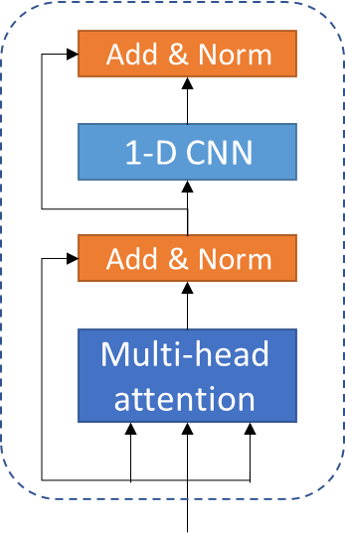

In [158]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.cnn = CNN(d_model, conv_hidden_dim)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

    def forward(self, x):

        # Multi-head attention
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)

        # Layer norm after adding the residual connection
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        # Feed forward
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)

        #Second layer norm after adding residual connection
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2

# Transformer Encoder

The encoder module of the transformer is comprised of the following architecture:

1.   Word embedding
2.   Positional encoding
3.   $N$ encoder layers

For word embedding we will again use the `nn.Embedding` utility, this time with the vocabulary generated from the current dataset.


In [159]:
NUM_WORDS = 50_000
from collections import Counter

def build_vocab(texts, max_size=50_000, min_freq=1):
    """
    Builds a vocabulary from training texts.

    Returns:
        stoi: dict[str, int]
        itos: list[str]
    """
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))

    # Reserve special tokens
    itos = ["<pad>", "<unk>"]

    # Most common words
    for word, freq in counter.most_common(max_size - len(itos)):
        if freq >= min_freq:
            itos.append(word)

    stoi = {word: idx for idx, word in enumerate(itos)}

    return stoi, itos


In [160]:
train_texts_for_vocab = [
    train_texts[i] for i in ds_train.indices
]

stoi, itos = build_vocab(
    train_texts_for_vocab,
    max_size=NUM_WORDS
)


In [161]:
vocab = {
    "stoi": stoi,
    "itos": itos
}
print(vocab["stoi"]["is"])
print(vocab["stoi"]["an"])


7
36


 For positional encoding, we will use shifted sinusoidals. Here the constant $p_{i,j}$ which  is added to the $j$th element (out of $d$) of the input vector at time instance $i$ is given by:
\begin{equation}
p_{i,j}=\begin{cases}
\sin\left(\frac{i}{10000^{j/d}}\right) & j\text{ is even}\\
\cos\left(\frac{i}{10000^{j/d}}\right) & j\text{ is odd}
\end{cases}
\end{equation}

In [162]:
def create_sinusoidal_embeddings(nb_i, dim, p_offset):
  # j is the index inside the vector and i is the time instance
    theta = np.array([
        [i / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_i)
    ])
    with torch.no_grad():
      p_offset[:, 0::2] = torch.tensor(np.sin(theta[:, 0::2]))
      p_offset[:, 1::2] = torch.tensor(np.cos(theta[:, 1::2]))
      p_offset.detach_()
    p_offset.requires_grad = False

Combining word embedding and positional encoding into a single *Embedding* input class

In [163]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = nn.Embedding(max_position_embeddings, d_model)
        create_sinusoidal_embeddings(
            nb_i=max_position_embeddings,
            dim=d_model,
            p_offset=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        # Get the position (time) ids for the input sequence.
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                      # (bs, max_seq_length)

        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)

        # Get position embeddings for each position id
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)

        # Add them both
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)

        # Layer norm
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

**Encoder Module:** We can now define the encoder module as a concatanation of the embedding model and a configurable number of encoder layers, where the output is merely the output of the final encoder layer.

In [164]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding):
        super().__init__()

        self.d_model = d_model # dictates how big are the vectors I am goigng to work with
        self.num_layers = num_layers

        self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers): # Multiple encoder layers
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim))

    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)

**Transformer Classifier:** The transformer classifier is just an encoder with a fully-connected layer applied to its output, mapping it into a $2\times 1$ vector for classification. Note that the sequence length here is limited to $10000$ words.

Since the dimensions of the encoder block output depend on the length of the input sequence, we need to combine the outputs for each sample (word). What we do here to that aim is take the per-entry max over all words.

In [165]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        x = self.encoder(x) # outputs the sequences of the same length of the input (batch_size, input_seq_len, d_model)
        # Recall in ths task we are interesting in sentiment analysis, we are looking of one vector that we will feed to DNN

        x, _ = torch.max(x, dim=1) # representation that does not depends on sequence length, takes the max value from each entry (batch_size, d_model)
        x = self.dense(x) # (batch_size, num_answers)
        return x

Let's apply

In [166]:
model = TransformerClassifier(num_layers=1, d_model=32, num_heads=2,
                         conv_hidden_dim=128, input_vocab_size=50003, num_answers=2).to(device) # size=50003 to consider <eob>, <bos>, <unk>

Training loss at epoch 0 is 0.7552637297009664
Training accuracy: 0.5433604144860827
Evaluating on validation:
Eval accuracy: 0.6006097396214803
Training loss at epoch 1 is 0.6534703279298449
Training accuracy: 0.6281455433557904
Evaluating on validation:
Eval accuracy: 0.6331300536791483
Training loss at epoch 2 is 0.614115802068559
Training accuracy: 0.6796360564610314
Evaluating on validation:
Eval accuracy: 0.6534552574157715
Training loss at epoch 3 is 0.5583933123520443
Training accuracy: 0.7173828615082635
Evaluating on validation:
Eval accuracy: 0.6951219240824381
Training loss at epoch 4 is 0.5085622947367411
Training accuracy: 0.7542585891390604
Evaluating on validation:
Eval accuracy: 0.713414599498113
Training loss at epoch 5 is 0.46008190891099354
Training accuracy: 0.7827138692613632
Evaluating on validation:
Eval accuracy: 0.7357723216215769
Training loss at epoch 6 is 0.4104457852386293
Training accuracy: 0.8137823939323425
Evaluating on validation:
Eval accuracy: 0.745

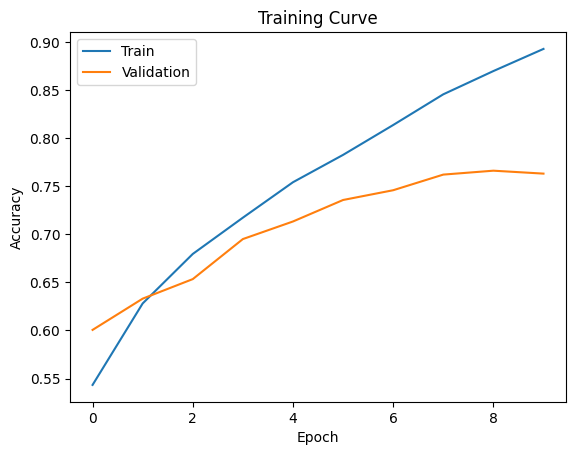

Eval accuracy: 0.7790869828817006


In [167]:
train(model, train_loader, valid_loader)

_ = evaluate(model, test_loader)

Let's see how many parameters do we have

In [168]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

print('Number of parameters: {}'.format(get_n_params(model)))


Number of parameters: 1932802
